In [ ]:
! pip install transformers datasets wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import cv2
import wandb
import os
import numpy as np
import urllib.request as urllib
import pandas as pd
import random
import torch

from PIL import ImageDraw, ImageFont, Image
from datasets import load_dataset, load_metric
from google.colab import auth
from google.cloud import storage
from google.colab import drive
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
ds = load_dataset('beans')

In [ ]:
ds['train'][400]

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

In [ ]:
drive.mount('/content/drive')
IMGS_DATA_ROOT = 'drive/MyDrive/AML_final_proj/Yoga-82-imgs/'

ds = load_dataset("imagefolder", data_dir=IMGS_DATA_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Resolving data files:   0%|          | 0/11743 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3351 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1772 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
ds["train"][54]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x160>,
 'label': 0}

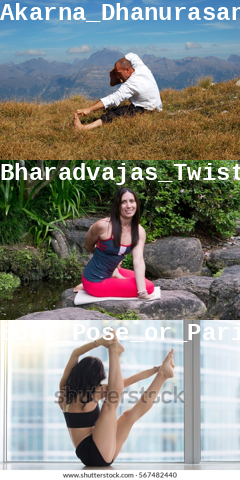

In [ ]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350), num_labels_to_show: int = 3):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels[:num_labels_to_show]) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels[:num_labels_to_show]):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=1, size=(240, 160), num_labels_to_show=3)

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
processor(ds["train"][0]['image'], return_tensors='pt')

{'pixel_values': tensor([[[[-0.2078, -0.2078, -0.2549,  ..., -0.2235, -0.2078, -0.2078],
          [-0.2078, -0.2078, -0.2000,  ..., -0.2157, -0.2078, -0.2078],
          [-0.2078, -0.2000, -0.1608,  ..., -0.1765, -0.2000, -0.2078],
          ...,
          [-0.2471, -0.2392, -0.1059,  ..., -0.1294, -0.2000, -0.2078],
          [-0.2235, -0.2314, -0.1843,  ..., -0.2078, -0.2078, -0.2078],
          [-0.1922, -0.1922, -0.2000,  ..., -0.2078, -0.2078, -0.2078]],

         [[ 0.5843,  0.5922,  0.6000,  ...,  0.5922,  0.5922,  0.5922],
          [ 0.6000,  0.6000,  0.6000,  ...,  0.5843,  0.5922,  0.5922],
          [ 0.5843,  0.5843,  0.5765,  ...,  0.5765,  0.5922,  0.5922],
          ...,
          [ 0.6078,  0.6078,  0.5608,  ...,  0.5608,  0.5922,  0.5922],
          [ 0.6000,  0.5922,  0.5765,  ...,  0.5922,  0.5922,  0.5922],
          [ 0.5843,  0.5765,  0.5765,  ...,  0.5922,  0.5922,  0.5922]],

         [[ 0.9765,  0.9686,  0.9765,  ...,  0.9608,  0.9765,  0.9765],
          [ 0

In [ ]:
processor(ds["train"][0]['image'], return_tensors='pt')['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Include labels
    inputs['label'] = example_batch['label']
    return inputs

In [ ]:
transformed_ds = ds.with_transform(transform)

In [ ]:
transformed_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.2078, -0.2078, -0.2549,  ..., -0.2235, -0.2078, -0.2078],
          [-0.2078, -0.2078, -0.2000,  ..., -0.2157, -0.2078, -0.2078],
          [-0.2078, -0.2000, -0.1608,  ..., -0.1765, -0.2000, -0.2078],
          ...,
          [-0.2471, -0.2392, -0.1059,  ..., -0.1294, -0.2000, -0.2078],
          [-0.2235, -0.2314, -0.1843,  ..., -0.2078, -0.2078, -0.2078],
          [-0.1922, -0.1922, -0.2000,  ..., -0.2078, -0.2078, -0.2078]],

         [[ 0.5843,  0.5922,  0.6000,  ...,  0.5922,  0.5922,  0.5922],
          [ 0.6000,  0.6000,  0.6000,  ...,  0.5843,  0.5922,  0.5922],
          [ 0.5843,  0.5843,  0.5765,  ...,  0.5765,  0.5922,  0.5922],
          ...,
          [ 0.6078,  0.6078,  0.5608,  ...,  0.5608,  0.5922,  0.5922],
          [ 0.6000,  0.5922,  0.5765,  ...,  0.5922,  0.5922,  0.5922],
          [ 0.5843,  0.5765,  0.5765,  ...,  0.5922,  0.5922,  0.5922]],

         [[ 0.9765,  0.9686,  0.9765,  ...,  0.9608,  0.9765,  0.9765],
          [ 0

In [ ]:
transformed_ds['train'][0:2]['pixel_values'].shape

torch.Size([2, 3, 224, 224])

In [ ]:
def collate_func(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-63-a00513a56fba>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
